In [1]:
from activations import *
from layer import *
from model import *
from optimizer import *
from accuracy import *
import numpy as np
import matplotlib.pyplot as plt
import os 
import cv2

In [2]:
# path to train folder
train_path = 'data/train'

# get all folders in train
label_names = sorted(os.listdir(train_path))  # sort to keep consistent order

# create a mapping: folder name -> integer label
label_map = {name: idx for idx, name in enumerate(label_names)}
print(label_map)


{'ace of clubs': 0, 'ace of diamonds': 1, 'ace of hearts': 2, 'ace of spades': 3, 'eight of clubs': 4, 'eight of diamonds': 5, 'eight of hearts': 6, 'eight of spades': 7, 'five of clubs': 8, 'five of diamonds': 9, 'five of hearts': 10, 'five of spades': 11, 'four of clubs': 12, 'four of diamonds': 13, 'four of hearts': 14, 'four of spades': 15, 'jack of clubs': 16, 'jack of diamonds': 17, 'jack of hearts': 18, 'jack of spades': 19, 'joker': 20, 'king of clubs': 21, 'king of diamonds': 22, 'king of hearts': 23, 'king of spades': 24, 'nine of clubs': 25, 'nine of diamonds': 26, 'nine of hearts': 27, 'nine of spades': 28, 'queen of clubs': 29, 'queen of diamonds': 30, 'queen of hearts': 31, 'queen of spades': 32, 'seven of clubs': 33, 'seven of diamonds': 34, 'seven of hearts': 35, 'seven of spades': 36, 'six of clubs': 37, 'six of diamonds': 38, 'six of hearts': 39, 'six of spades': 40, 'ten of clubs': 41, 'ten of diamonds': 42, 'ten of hearts': 43, 'ten of spades': 44, 'three of clubs':

In [3]:
def load_card_dataset(subset, path, label_map, target_size=(32, 32)):
    """
    subset : 'train', 'test', 'valid'
    path   : root folder containing all subsets
    label_map : dictionary mapping folder names to integer labels
    target_size: tuple of (width, height) to resize images
    """
    X = []
    y = []

    subset_path = os.path.join(path, subset)

    # iterate over each label folder
    for label_name in sorted(os.listdir(subset_path)):
        folder_path = os.path.join(subset_path, label_name)

        # iterate over images in the folder (sort to ensure consistent order)
        for file in sorted(os.listdir(folder_path)):
            image_path = os.path.join(folder_path, file)
            image = cv2.imread(image_path, cv2.IMREAD_COLOR)  # keep 3 channels
            if image is None:
                continue  # skip unreadable images
            # resize the image
            image = cv2.resize(image, target_size)
            X.append(image)
            y.append(label_map[label_name])

    # convert to numpy arrays
    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.uint8)

    return X, y


In [4]:
def create_card_data(path, target_size=(32, 32)):
    # create label map from train folder
    train_folders = sorted(os.listdir(os.path.join(path, 'train')))
    label_map = {name: idx for idx, name in enumerate(train_folders)}

    # load datasets
    X_train, y_train = load_card_dataset('train', path, label_map, target_size)
    X_valid, y_valid = load_card_dataset('valid', path, label_map, target_size)
    X_test, y_test = load_card_dataset('test', path, label_map, target_size)

    # shuffle training dataset
    keys = np.arange(X_train.shape[0])
    np.random.shuffle(keys)
    X_train, y_train = X_train[keys], y_train[keys]

    # normalize to [-1,1] 
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5
    X_valid = (X_valid.astype(np.float32) - 127.5) / 127.5
    X_test = (X_test.astype(np.float32) - 127.5) / 127.5

    # flatten for Dense network
    X_train = X_train.reshape(X_train.shape[0], -1)
    X_valid = X_valid.reshape(X_valid.shape[0], -1)
    X_test = X_test.reshape(X_test.shape[0], -1)

    return X_train, y_train, X_valid, y_valid, X_test, y_test


In [5]:
dataset_path = 'data'

# create label map once using train folder
label_names = sorted(os.listdir(os.path.join(dataset_path, 'train')))
label_map = {name: idx for idx, name in enumerate(label_names)}

# load each subset
X_train, y_train = load_card_dataset('train', dataset_path, label_map)
X_test, y_test = load_card_dataset('test', dataset_path, label_map)
X_valid, y_valid = load_card_dataset('valid', dataset_path, label_map)


In [6]:
print(X_train.shape)

(7624, 32, 32, 3)


In [7]:
X_train, y_train, X_valid, y_valid, X_test, y_test = create_card_data('data')


In [8]:
print(X_train.shape)

(7624, 3072)


In [9]:
model = Model()
# 32 x 32 x 3
# 1.74 million parameters
model.add(DenseLayer(X_train.shape[1], 512, weight_regularizer_L2=1e-5))
model.add(ReLU())
model.add(DropoutLayer(0.2))

model.add(DenseLayer(512, 256, weight_regularizer_L2=1e-5))
model.add(ReLU())
model.add(DropoutLayer(0.2))

model.add(DenseLayer(256, 128, weight_regularizer_L2=1e-5))
model.add(ReLU())
model.add(DropoutLayer(0.2))

model.add(DenseLayer(128, 53))
model.add(SoftMax())

# Set loss, optimizer and accuracy objects
model.set(
    loss=CategoricalCrossEntropyLoss(),
    optimizer=Adam(learning_rate=0.0015,decay=1e-4),
    accuracy=Categorical()
)
# Finalize the model
model.finalize()

# Train the model 
model.train(X_train.reshape(X_train.shape[0], -1), y_train, 
validation_data=(X_test.reshape(X_test.shape[0], -1), y_test),
epochs=50, batch_size=64, print_every=100)

epoch: 1
step: 0, acc: 0.000, loss: 3.972 (data_loss: 3.970, reg_loss: 0.002), lr: 0.0015
step: 100, acc: 0.141, loss: 2.999 (data_loss: 2.992, reg_loss: 0.006), lr: 0.0014851485148514852
step: 119, acc: 0.125, loss: 2.915 (data_loss: 2.907, reg_loss: 0.007), lr: 0.0014823599169878447

training : acc: 0.065, loss: 3.539 (data_loss: 3.531, reg_loss: 0.007), lr: 0.0014823599169878447
validation : acc: 0.125, loss: 2.852

epoch: 2
step: 0, acc: 0.094, loss: 3.285 (data_loss: 3.277, reg_loss: 0.007), lr: 0.0014822134387351778
step: 100, acc: 0.219, loss: 2.402 (data_loss: 2.390, reg_loss: 0.012), lr: 0.0014677103718199608
step: 119, acc: 0.500, loss: 2.053 (data_loss: 2.040, reg_loss: 0.013), lr: 0.001464986815118664

training : acc: 0.177, loss: 2.870 (data_loss: 2.857, reg_loss: 0.013), lr: 0.001464986815118664
validation : acc: 0.253, loss: 2.456

epoch: 3
step: 0, acc: 0.188, loss: 2.867 (data_loss: 2.854, reg_loss: 0.013), lr: 0.00146484375
step: 100, acc: 0.406, loss: 2.120 (data_los

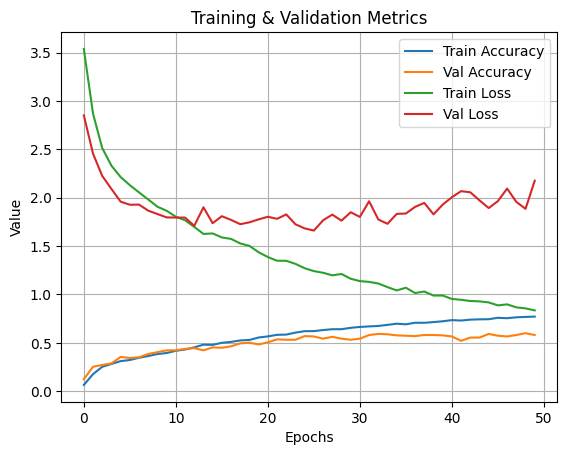

In [13]:
# Accuracy
plt.plot(model.history['train_acc'], label='Train Accuracy')
plt.plot(model.history['val_acc'], label='Val Accuracy')

# Loss
plt.plot(model.history['train_loss'], label='Train Loss')
plt.plot(model.history['val_loss'], label='Val Loss')

plt.xlabel("Epochs")
plt.ylabel("Value")
plt.title("Training & Validation Metrics")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def get_predictions(model, X):
    # get the predictions and return it 
    output = model.forward(X, training=False)
    predictions = model.output_layer_activation.predictions(output)
    return predictions

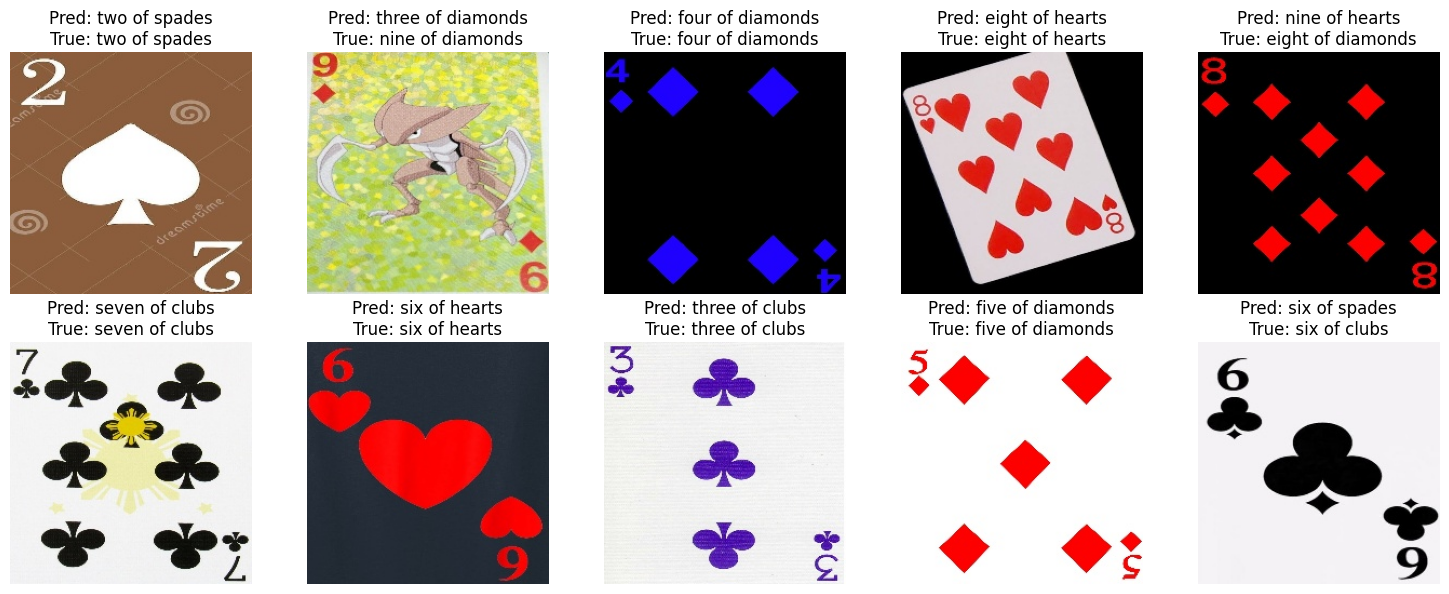

In [25]:
from PIL import Image

# Reverse the mapping
idx_to_label = {v: k for k, v in label_map.items()}

# Select 10 random test samples
indices = np.random.choice(len(X_test), 10)
images = X_test[indices]
labels_true = y_test[indices]

plt.figure(figsize=(15, 6))
for i, idx in enumerate(indices):
    # Get prediction
    pred_label = get_predictions(model, X_test[idx].reshape(1, -1))[0]

    # Load original image from the dataset path
    label_name = idx_to_label[labels_true[i]]
    img_path = f"data/test/{label_name}/{os.listdir(f'data/test/{label_name}')[0]}"  
    img = Image.open(img_path)

    # Show image
    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.title(f"Pred: {idx_to_label[pred_label]}\nTrue: {label_name}")
    plt.axis('off')

plt.tight_layout()
plt.show()
